# NON-NEGATIVE MATRIX FACTORISATION FOR TOPIC EXTRACTION
## Anfu TANG

### TOPIC EXTRACTION FROM DOCUMENTS 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning
from __future__ import print_function
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from sklearn.datasets import fetch_20newsgroups
from numpy.linalg import svd
from ipywidgets import IntProgress
from IPython.display import display

In [2]:
n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20

In [3]:
def print_top_words(model, feature_names, n_top_words):
    for (topic_idx, topic) in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]
                            ])
        print(message)
    print()

In [4]:
# Load the 20 newsgroups dataset and vectorize it. We use a few
#heuristics to filter out useless terms early on: the posts are
# stripped of headers, footers and quoted replies, and common
# English words, words occurring in only one document or in at
# least 95% of the documents are removed.
print("Loading dataset...")
t0 = time()
dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))

data_samples = dataset.data[:n_samples]
print("done in %0.3fs." % (time() - t0))

# Use tf-idf features for NMF.
print("Extracting tf-idf features...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

Loading dataset...
done in 1.758s.
Extracting tf-idf features...
done in 0.447s.


In [5]:
# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components,solver="mu",random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000...
done in 0.719s.

Topics in NMF model (Frobenius norm):
Topic #0: just people don think like know good time make way really right say ve want did ll new government use
Topic #1: windows use dos using card window help program pc software drivers video os application looking ftp running version files screen
Topic #2: god jesus bible faith christian does christ christians heaven sin believe lord life church mary atheism belief human love religion
Topic #3: thanks know mail advance does interested info hi email anybody list like send new address post bike reply appreciated buying
Topic #4: 00 sale 10 car condition price new card offer 250 15 12 asking 11 20 50 25 year 30 16
Topic #5: edu soon com university internet send mit ftp cc article information hope need email home blood pub mac mail cs
Topic #6: file files problem format win sound pub read ftp save windows site running create self copy

**Q1. Test and comment on the effect of varying the initialisation, especially using random
nonnegative values as initial guesses (for W and H coefficients, using the notations introduced
during the lecture).**

In [6]:
# Fit the NMF model
nmf = NMF(n_components=n_components, init="random",solver="mu",random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("\nTopics in NMF model with random inits(Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)


Topics in NMF model with random inits(Frobenius norm):
Topic #0: just thought wondering don sure listen like wrong mean bad does argument oh want book driving heard doesn really ll
Topic #1: people government don law know say make israel rights did right evidence person point like said state gun true mr
Topic #2: good bike want use luck don buy course need better using say recommend thing later look quality deleted try doesn
Topic #3: think don win extra use early bible need pretty sold means sex yes wasn toronto try reading david happen course
Topic #4: windows file dos files program using problem window help use os drivers pc ftp running application ms software card screen
Topic #5: god jesus bible faith christian christ christians does heaven sin believe life lord mary church love atheism human belief religion
Topic #6: key chip clipper keys encryption use government public secure phone enforcement encrypted communications nsa used security standard clinton data user
Topic #7: than

Compare these 10 topics here to thoses obtained using initial guesses given by nndsvd method(default), we can find that there are just several pairs between each of them there are strong correspondence:(nndsvd->random)1->4,2->5,3->7,5->9,9->6.
For those who does not have an obvious correspondence, words in the topic appear to like randomly chosen.This implicates that random guesses does not give a result enough precise. 

The reason is that in the NMF algorithm, no matter coordinate descent method(default) or multiplicative update method is based on gradient,thus the minimum attained is local minimum, and for a local optimisation problem. there may exist many local minimas. Therefore, initial W,H given are more precise, the result will be more precise.

**Q2.Compare and comment on the difference between the results obtained with l2 cost compared
to the generalised Kullback-Liebler cost.**

In [7]:
# Fit the NMF model
nmf = NMF(n_components=n_components, solver="mu",beta_loss="kullback-leibler",random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("\nTopics in NMF model using Kullback-Liebler cost:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)


Topics in NMF model using Kullback-Liebler cost:
Topic #0: people just like time don say really know way things make think right said did want ve probably work years
Topic #1: windows thanks using help need hi work know use looking mail software does used pc video available running info advance
Topic #2: god does true read know say believe subject says religion mean question point jesus people book christian mind understand matter
Topic #3: thanks know like interested mail just want new send edu list does bike thing email reply post wondering hear heard
Topic #4: time new 10 year sale old offer 20 16 15 great 30 weeks good test model condition 11 14 power
Topic #5: use number com government new university data states information talk phone right including security provide control following long used research
Topic #6: edu try file soon remember problem com program hope mike space article wrong library short include win little couldn sun
Topic #7: year world team game play won win game

It is obvious that in case where L2 cost is used, key words in a topic are more representive and relates to the topic more closely. We can compare these two costs by their expressions:

(frobenius/L2 cost) $d_{Fro}(\mathbf{X},\mathbf{WH})=\sum_{i,j}||\mathbf{X}-\mathbf{WH}||^2$

(kullback-liebler cost)$d_{KL}(\mathbf{X},\mathbf{WH})=\sum_{i,j}{(\mathbf{X}log\frac{\mathbf{X}}{\mathbf{WH}}-\mathbf{X}+\mathbf{WH})}$

These two costs have evidently different convergence speed, thus they apply for different situations. We can conclude that for tfidf results, kullback-liebler cost is not suitable.


**Q3.Test and comment on the results obtained using a simpler term-frequency representation
as input (as opposed to the TF-IDF representation considered in the code above) when
considering the Kullback-Liebler cost.**

In [8]:
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
countvec = count_vectorizer.fit_transform(data_samples)

# Fit the NMF model
nmf = NMF(n_components=n_components, solver="mu",beta_loss="kullback-leibler",random_state=1,
          alpha=.1, l1_ratio=.5).fit(countvec)
print("\nTopics in NMF model using Kullback-Liebler cost(CountVectorizer):")
count_feature_names = count_vectorizer.get_feature_names()
print_top_words(nmf, count_feature_names, n_top_words)


Topics in NMF model using Kullback-Liebler cost(CountVectorizer):
Topic #0: edu com mail thanks windows send graphics file use help stuff pub files computer using server image email message ftp
Topic #1: drive hard disk card drives speed scsi controller power 16 rom bios use floppy high feature board memory interface supports
Topic #2: people just know don like did going think said didn ve ll time got come right say want old things
Topic #3: 10 55 11 15 20 25 18 12 00 16 40 22 17 19 23 21 13 26 24 30
Topic #4: new public 000 hiv research national children year health time 1993 care president states information aids greek american cost insurance
Topic #5: version type available pc number contact program mac software phone machines dos comments university edu ibm ftp runs written anonymous
Topic #6: law key government use state used israel chip section person encryption keys clipper means gun control weapons military following shall
Topic #7: space earth years moon surface probe science

We have two points to conclude from comparisons:1.If the kullback-leibler cost is used, using simple term-frequency performs better than using tf-idf representations;2.If we both use frobenius cost, tf-idf representation performs better than term-frequency. 

The main reason is that the matrix calculated by tfidfVectorizer is less sparse which makes it harder to converge, while the matrix of countVectorizer is more sparse and easier to converge. it is why Frobenius here frobenius cost suits for tfidfVectorizer, and kullback-leibler cost suits for countVectorizer.

### CUSTOM NMF IMPLEMENTATION 

In [9]:
def beta_divergence(A,B,beta):
    '''
    function:calculate the error between matrix A and B based on beta
    return:error d(A|B)
    '''
    #avoid division by 0
    nul = np.finfo(np.float).tiny
    A = np.clip(A, 10**-50, None)
    B = np.clip(B, 10**-50, None)
    if beta==0:
        divergence = np.sum((A/B-np.log(A/B)-1))
    if beta==1:
        divergence = np.sum((np.ma.multiply(A,np.log(A/B))-A+B))
    if beta>1:
        divergence = np.sum(((1/(beta*(beta-1)))*((A**beta)+(beta-1)*(B**beta)-
                                                beta*np.ma.multiply(A,(B**(beta-1))))))
    return np.sqrt(divergence)

In [10]:
def update_H(W,H,V,beta):
    WH = W.dot(H)
    I = np.ones(WH.shape)
    if beta==0:
        numerator = (W.T).dot(np.ma.multiply(np.divide(I,WH**2),V))
        denominator = W.T.dot(np.ma.divide(I,WH))
    if beta==1:
        numerator = (W.T).dot(np.ma.multiply(np.ma.divide(I,WH),V))
        denominator = (W.T).dot(I)
    if beta>1:
        numerator = (W.T).dot(np.ma.multiply(WH**(beta-2),V))
        denominator = (W.T).dot(WH**(beta-1))
    updated_H = np.ma.multiply(H,np.ma.divide(numerator,denominator))
    
    return updated_H

In [11]:
def update_W(W,H,V,beta):
    WH = np.dot(W,H)
    I = np.ones(WH.shape)
    if beta==0:
        numerator = np.dot(np.ma.multiply(np.divide(I,WH**2),V),H.T)
        denominator = np.dot(np.ma.divide(I,WH),H.T)
    if beta==1:
        numerator = np.dot(np.ma.multiply(np.ma.divide(I,WH),V),H.T)
        denominator = I.dot(H.T)
    if beta>1:
        numerator = np.dot(np.ma.multiply(WH**(beta-2),V),H.T)
        denominator = np.dot(WH**(beta-1),H.T)
    updated_W = np.ma.multiply(W,np.ma.divide(numerator,denominator))
    return updated_W

In [12]:
def custom_NMF(V,W=None,H=None,num_components=10,init="random",num_iter=20,beta=2):
    '''
    parameters:
    V - matrix to be factorised
    init - set initialisation,must be a string in:{"random","custom"}
           if "custom", W,H must be given
    num_iter - number of iterations
    beta - beta of divergence, must be an integer(beta>=0)
    
    return:
    updated W,H
    '''
    np.seterr(all='ignore')
    n_samples = V.shape[0]
    n_features = V.shape[1]
    #initialisation
    if init=="random":
        W = np.random.random((n_samples,num_components))
        H = np.random.random((num_components,n_features))
    if init=="custom":
        if W.shape!=(n_samples,num_components) or H.shape!=(num_components,n_features):
            print("error!W or H does not have a right shape!")
    #multiplicative update
    #visulize progress
    pro = IntProgress(max=num_iter)
    pro.description = "updating"
    display(pro)
    start = time()
    b_div = []
    for ite in range(num_iter):
        #update H
        H = update_H(W,H,V,beta)
        #update W
        W = update_W(W,H,V,beta)
        #limit W and H to avoid overflow
        H = np.clip(H, 10**-150, None)
        W = np.clip(W, 10**-150, None)
        #show error
        #print("divergence of iteration %d: %.6f"%(ite,beta_divergence(V,np.dot(W,H),beta)))
        b_div.append(beta_divergence(V,np.dot(W,H),beta))
        pro.value += 1
    end = time()
    pro.description = "done(%.1fs)" % (end-start)
    #plot the curve of divergence
    iterations = np.linspace(1,num_iter,num_iter)
    plt.figure(figsize=(6,4))
    plt.plot(iterations,b_div)
    plt.title("beta=%d"%(beta))
    plt.xlabel("iterations")
    plt.ylabel("beta divergence")
    plt.show()
    
    return W,H

**Implementation Result**

Our algorithm fulfills the three requests proposed in the instruction. (1)custom initialisation can be entered as parameters, while setting parameter init "custom";(2)number of iterations can be set by parameter num_iter;(3)we can monitor the behaviour of loss function by setting different values of beta, and it will be shown in the form of a curve that during iterations, the loss readily decreases. 

## Comparison
We compare our algorithm to the sklearn NMF algorithm in two aspects:(1)reconstruction error between WH and original V;(2)results of topic extraction.

**(1)comparison on beta divergence(reconstruction error)**

In [13]:
#calculate reconstruction error of sklearn NMF.
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
tf = tfidf.toarray()
nmf = NMF(n_components=n_components,max_iter=30,init="random",beta_loss=2,solver="mu",random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
nmf_w=nmf.fit_transform(tfidf)
nmf_h=nmf.components_
nmf_v=nmf_w.dot(nmf_h)
#calculate frobenius cost for validation
print("divergence calculated manually:%.6f"%(np.sum((nmf_v-tf)**2)))

divergence calculated manually:1781.723211


In [14]:
print("reconstruction error given by sklearn NMF:%.6f"%(nmf.reconstruction_err_))
print("its square:%.6f"%(np.power(nmf.reconstruction_err_,2)))

reconstruction error given by sklearn NMF:42.210463
its square:1781.723211


Thus, it should be noticed that in sklearn NMF, beta divergence is usually small than the one in our algorithm because it outputs the square root.
We make a modification in our algorithm for better comparison. In later comparison, we keep 30 iterations with random guesses,and test two cases in which $\beta=1,2$.

IntProgress(value=0, description='updating', max=30)

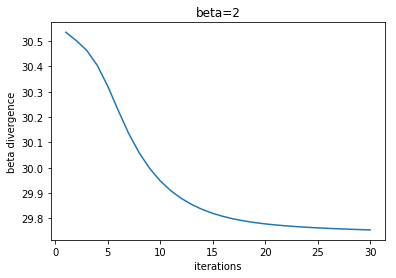

In [15]:
w,h = custom_NMF(tf,num_iter=30,beta=2)

Our algorithm gives a smaller divergence because actually in our algorithm in case of $\beta=2$,

$D(V,WH)=\sum_{i,j}\frac{1}{2}||V-WH||^2$

Therefore, our algorithm in fact functions as well as sklearn in this point, except for speed.

In [16]:
nmf = NMF(n_components=n_components,max_iter=30,init="random",beta_loss=1,solver="mu",random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("reconstruction error given by sklearn NMF:%.6f"%(nmf.reconstruction_err_))

reconstruction error given by sklearn NMF:214.005759


IntProgress(value=0, description='updating', max=30)

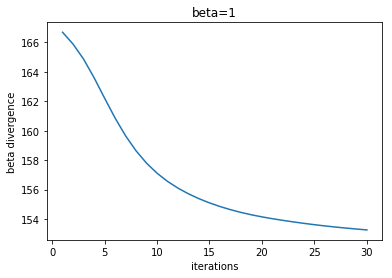

In [17]:
w,h = custom_NMF(tf,num_iter=30,beta=1)

We still have similar performances when $\beta=1$.

**(2)comparison on topics extracted**

In [18]:
nmf = NMF(n_components=n_components,init="random",beta_loss=2,solver="mu",random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("Topics extracted for sklearn NMF:")
print_top_words(nmf, tfidf_feature_names, n_top_words)

Topics extracted for sklearn NMF:
Topic #0: just thought wondering don sure listen like wrong mean bad does argument oh want book driving heard doesn really ll
Topic #1: people government don law know say make israel rights did right evidence person point like said state gun true mr
Topic #2: good bike want use luck don buy course need better using say recommend thing later look quality deleted try doesn
Topic #3: think don win extra use early bible need pretty sold means sex yes wasn toronto try reading david happen course
Topic #4: windows file dos files program using problem window help use os drivers pc ftp running application ms software card screen
Topic #5: god jesus bible faith christian christ christians does heaven sin believe life lord mary church love atheism human belief religion
Topic #6: key chip clipper keys encryption use government public secure phone enforcement encrypted communications nsa used security standard clinton data user
Topic #7: thanks know does advance m

IntProgress(value=0, description='updating', max=200)

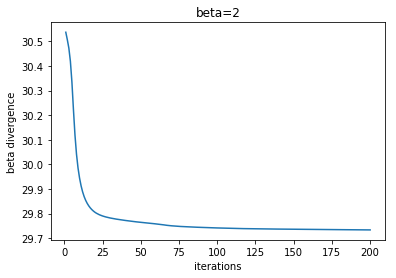

Topics extracted for our custom NMF:
Topic #0: god jesus bible faith does christian christians christ believe life heaven sin lord church religion mary love good true human
Topic #1: key chip clipper keys encryption government use public phone secure enforcement data nsa law going communications doesn security encrypted used
Topic #2: edu soon com send university internet mail ftp mit information article pub cc address email hope contact blood program mac
Topic #3: windows file problem dos using use files program window software help pc os running drivers version available application screen work
Topic #4: people did time law government know say israel said rights let state make right don evidence point gun case crime
Topic #5: car new 00 drive power 10 price sale bike good cars speed used condition old engine space year 16 buy
Topic #6: just don like got ll sure really thought ve way right look want wrong mean doesn know isn thing good
Topic #7: thanks know does mail advance hi info i

In [19]:
w,h = custom_NMF(tf,num_iter=200,beta=2)
print("Topics extracted for our custom NMF:")
for (topic_idx, topic) in enumerate(h):
        message = "Topic #%d: " % topic_idx
        message += " ".join([tfidf_feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]
                            ])
        print(message)

We can build several direct correspondence between the results:(sklearn,custom)0->6, 1->4, 4->3, 5->0, 6->1, 7->7, 8->5, 9->2. For these other topics in the results, both two algorithms give ambiguous key words. In this sense, our algorithm performs as well as sklearn. 